In [1]:
from collections import defaultdict
import json
from glob import glob
from typing import Tuple

from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
from numpy import exp
import pandas as pd
from scipy.signal import find_peaks
import seaborn as sns

from statistics import kolmogorov_smirnov
from utils import dict_sum, as_series, as_dataframe, to_cumulative, pool_counts_to_dataframe
from views import plot_distribution_comparison

mpl.rcParams['lines.linewidth'] = 2.5

# Base line variant distribution

In [2]:
from utils import pool_counts_to_dataframe3

In [3]:
normals, variants = pool_counts_to_dataframe(glob('output/tumor_derived/*.json'))

In [ ]:
def make_panel(filenames):
    dfs = []
    for f in filenames:
        dfs.extend(load_json_as_data_frame(f))
        
    indices, columns = determine_dimensions(dfs)
    

In [ ]:
make_panel(glob('output/tumor_derived/*.json'))

In [6]:
def plot_distribution_with_peaks(seq, label=None):
    n = 5
    peak_constaints = {"width": 15, "distance": 50, "rel_height": 0.85}
    seq /= sum(seq)
    peaks, properties = find_peaks(seq.rolling(n).mean(), **peak_constaints)

    fragment_window = [50, 500]
    seq.plot(label=label, zorder=0)
    plt.plot(peaks, seq[peaks], "o", zorder=1)
    plt.hlines(
        y=properties["width_heights"],
        xmin=properties["left_ips"],
        xmax=properties["right_ips"],
        color="C1",
        zorder=2,
    )
    plt.xlim(fragment_window)

# Everything together


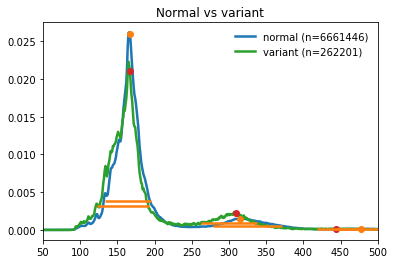

In [7]:
plt.title('Normal vs variant')
plot_distribution_with_peaks(normals.sum(axis=1), label=f'normal (n={normals.sum().sum()})')
plot_distribution_with_peaks(variants.sum(axis=1), label=f'variant (n={int(variants.sum().sum())})')
plt.legend(frameon=False)
plt.savefig('figs/normal_variant.png')

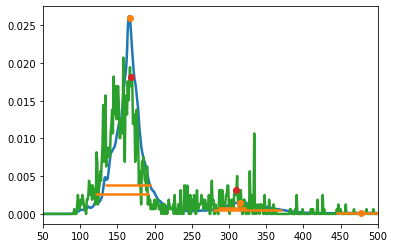

In [8]:
plot_distribution_with_peaks(normals.sum(axis=1), label='normal')
plot_distribution_with_peaks(variants['ROS1'])

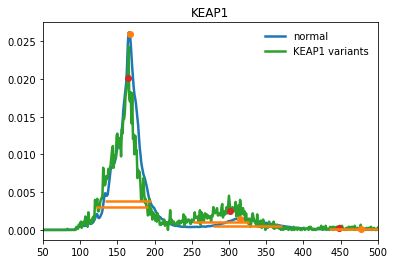

In [9]:
plt.title('KEAP1')
plot_distribution_with_peaks(normals.sum(axis=1), label='normal')
plot_distribution_with_peaks(variants['KEAP1'], label='KEAP1 variants')
plt.legend(frameon=False)
plt.savefig('figs/keap1.png')

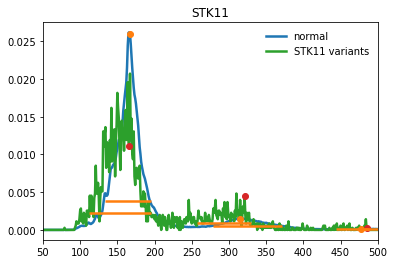

In [10]:
plt.title('STK11')
plot_distribution_with_peaks(normals.sum(axis=1), label='normal')
plot_distribution_with_peaks(variants['STK11'], label='STK11 variants')
plt.legend(frameon=False)
plt.savefig('figs/stk11.png')

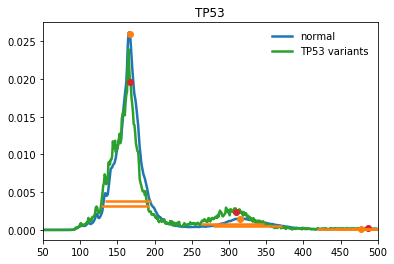

In [11]:
plt.title('TP53')
plot_distribution_with_peaks(normals.sum(axis=1), label='normal')
plot_distribution_with_peaks(variants['TP53'], label='TP53 variants')
plt.legend(frameon=False)
plt.savefig('figs/tp53.png')

In [12]:
def compare_peak_shifts(variant_distribution, reference_distribution):
    """
    Calculate the peak position and width for each gene distribution, and compare to reference distributions.
    
    Focus on distributions that are statistically significant.
    """
    n = 5  # Number of base pair smoothing.
    peak_constaints = {'width': 15, 'distance': 80, 'rel_height': 0.85}
    ref_peaks, ref_properties = find_peaks(reference_distribution.rolling(n).mean(), **peak_constaints)
    
    def peak_shift(sequence, num_peaks=2):
        """ Calculate shift and broadening for given sequence. """
        peaks, props = find_peaks(sequence.rolling(n).mean(), **peak_constaints)
        max_peaks = min(num_peaks, len(peaks), len(ref_peaks))
       
        s1 = pd.Series({
            f'{peak_number+1}_shift': peaks[peak_number] - ref_peaks[peak_number]
            for peak_number in range(max_peaks)
        })
        print(s1.index)
        s2 = pd.Series({
            f'{peak_number+1}_broadening': props['widths'][peak_number] - ref_properties['widths'][peak_number]
            for peak_number in range(max_peaks)
        })
        return pd.concat([s1,s2])

    # Filter columns on statistical significance.
    significant_columns = tuple(
        c 
        for c in variant_distribution.columns 
        if kolmogorov_smirnov(reference_distribution, variant_distribution[c]) < 0.05
    )
    # Calculate shift for each gene.
    data_frame = pd.DataFrame(columns=significant_columns)
    for c in significant_columns:
        print(c)
        data_frame[c] = peak_shift(variant_distribution[c])
    return data_frame


In [13]:
df = compare_peak_shifts(variants, normals.sum(axis=1)).T

ABL1
Index(['1_shift', '2_shift'], dtype='object')
APC
Index(['1_shift', '2_shift'], dtype='object')
AR
Index(['1_shift', '2_shift'], dtype='object')
BRAF
Index(['1_shift', '2_shift'], dtype='object')
CDK4
Index(['1_shift', '2_shift'], dtype='object')
CDK6
Index(['1_shift', '2_shift'], dtype='object')
CDKN2A
Index(['1_shift', '2_shift'], dtype='object')
CTNNB1
Index(['1_shift', '2_shift'], dtype='object')
EGFR
Index(['1_shift', '2_shift'], dtype='object')
ERBB2
Index(['1_shift', '2_shift'], dtype='object')
ESR1
Index(['1_shift', '2_shift'], dtype='object')
FLT1
Index(['1_shift', '2_shift'], dtype='object')
IDH1
Index(['1_shift', '2_shift'], dtype='object')
KRAS
Index(['1_shift', '2_shift'], dtype='object')
MSH2
Index(['1_shift', '2_shift'], dtype='object')
NFE2L2
Index(['1_shift', '2_shift'], dtype='object')
NRAS
Index([], dtype='object')
PDGFRB
Index(['1_shift', '2_shift'], dtype='object')
PMS2
Index(['1_shift', '2_shift'], dtype='object')
PTCH1
Index(['1_shift', '2_shift'], dtype='ob

In [14]:
def plot_peak(df, peak_number: int):
#     plt.figure(figsize=(4,3))
    plt.title(f'Peak {peak_number}')
    x_column = f'{peak_number}_shift'
    y_column = f'{peak_number}_broadening'
    xlim = (min(df[x_column])-2, max(df[x_column])+2)
    ylim = (min(df[y_column])-2, max(df[y_column])+2)
    plt.plot([0, 0], ylim, '-k', zorder=1, alpha=0.5)
    plt.plot(xlim, [0, 0], '-k', zorder=1, alpha=0.5)

    plt.xlim(xlim)
    plt.ylim(ylim)
    sns.scatterplot(
        x=x_column, 
        y=y_column, 
        hue=df.index,
        data=df,
        zorder=2,
    )
    plt.ylabel('Broadening (bp)')
    plt.xlabel('Shift (bp)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

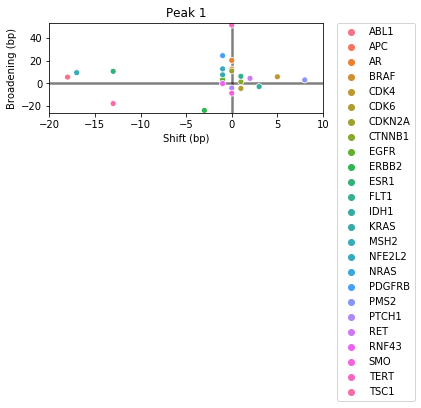

In [15]:
plot_peak(df, peak_number=1)
plt.savefig('figs/peak1.png', bbox_inches='tight')

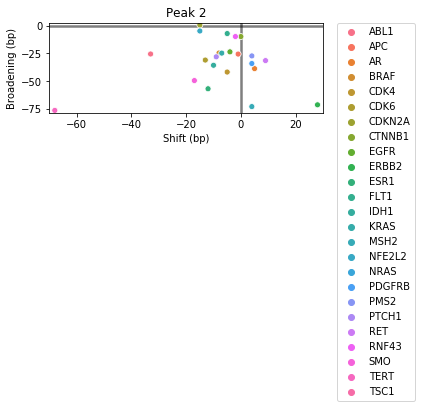

In [16]:
plot_peak(df, peak_number=2)
plt.savefig('figs/peak2.png', bbox_inches='tight')

[167 309]
[35.77491146 38.76366357]


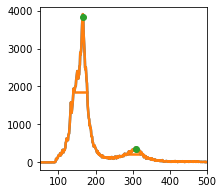

In [17]:
plt.figure(figsize=(3, 3))
from scipy.signal import find_peaks

seq = variants.sum(axis=1)
n = 5
peaks, properties = find_peaks(seq.rolling(n).mean(), width=15, distance=100)
print(peaks)
print(properties['widths'])
seq.plot()
seq.plot()
fragment_window = [50, 500]
plt.xlim(fragment_window)
plt.plot(peaks, seq[peaks], 'o')
plt.hlines(y=properties["width_heights"], xmin=properties["left_ips"],
           xmax=properties["right_ips"], color = "C1")

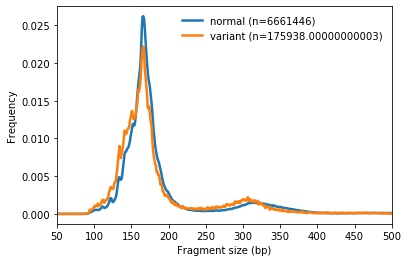

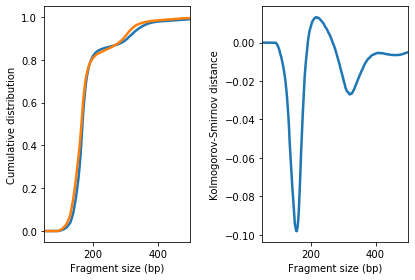

In [18]:
plot_distribution_comparison(normals.sum(axis=1), variants.sum(axis=1), filename_suffix='all')

In [19]:
# for gene in normals.columns:
#     f = plt.figure(figsize=(8,3))
#     plt.title(gene)
#     plot_distribution_comparison(normals[gene], variants[gene])

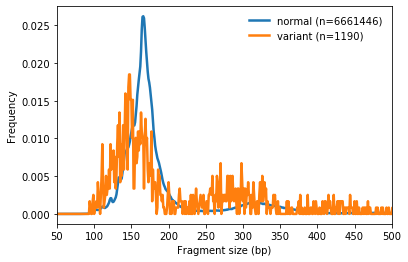

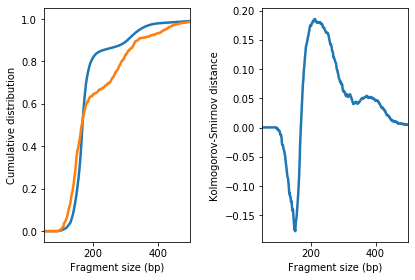

In [20]:
plot_distribution_comparison(normals.sum(axis=1), variants['ABL1'], filename_suffix='EGFR')

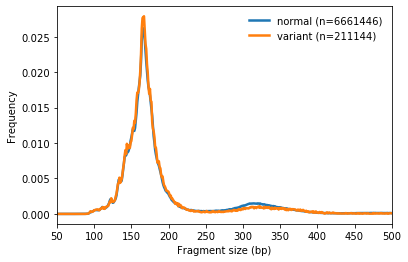

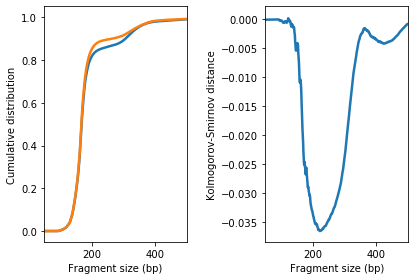

In [21]:
plot_distribution_comparison(normals.sum(axis=1), normals['EGFR'], filename_suffix='EGFR')

In [22]:
# Check that all normal genes are not significantly different.
significant_columns = tuple(
    c 
    for c in normals.columns 
    if kolmogorov_smirnov(normals.sum(axis=1), normals[c]) < 0.05/len(normals.columns)
)
significant_columns

('ABL1',
 'AKT2',
 'APC',
 'AR',
 'ARAF',
 'BRAF',
 'BRCA1',
 'CCND2',
 'CDKN2A',
 'CSF1R',
 'CTNNB1',
 'DDR2',
 'ERBB2',
 'ESR1',
 'FLT4',
 'GATA3',
 'IDH1',
 'KDR',
 'KEAP1',
 'KIT',
 'MAP2K1',
 'MSH6',
 'MTOR',
 'NFE2L2',
 'NRAS',
 'PDCD1LG2',
 'PDGFRA',
 'PDGFRB',
 'PMS2',
 'PTCH1',
 'RAF1',
 'RET',
 'RNF43',
 'ROS1',
 'STK11',
 'TERT',
 'TP53',
 'TSC1',
 'TSC2')

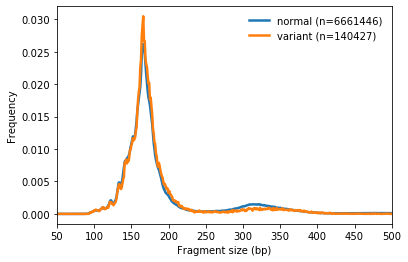

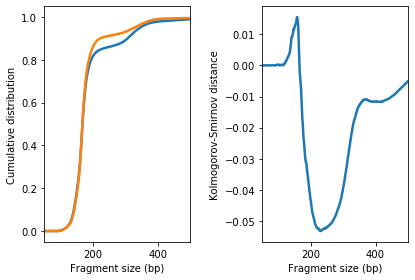

In [23]:
plot_distribution_comparison(normals.sum(axis=1), normals['ROS1'])